In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [13]:
# Install opendatasets
!pip install opendatasets

import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/biancaferreira/african-wildlife'

od.download(dataset_url)
# Define paths
base_dir = 'african-wildlife'
# The dataset has 4 folders: buffalo, elephant, rhino, zebra
classes = sorted(os.listdir(base_dir))
print(f"Classes: {classes}")

Skipping, found downloaded files in "./african-wildlife" (use force=True to force download)
Classes: ['buffalo', 'elephant', 'rhino', 'zebra']


Classes found: ['rhino', 'buffalo', 'elephant', 'zebra']


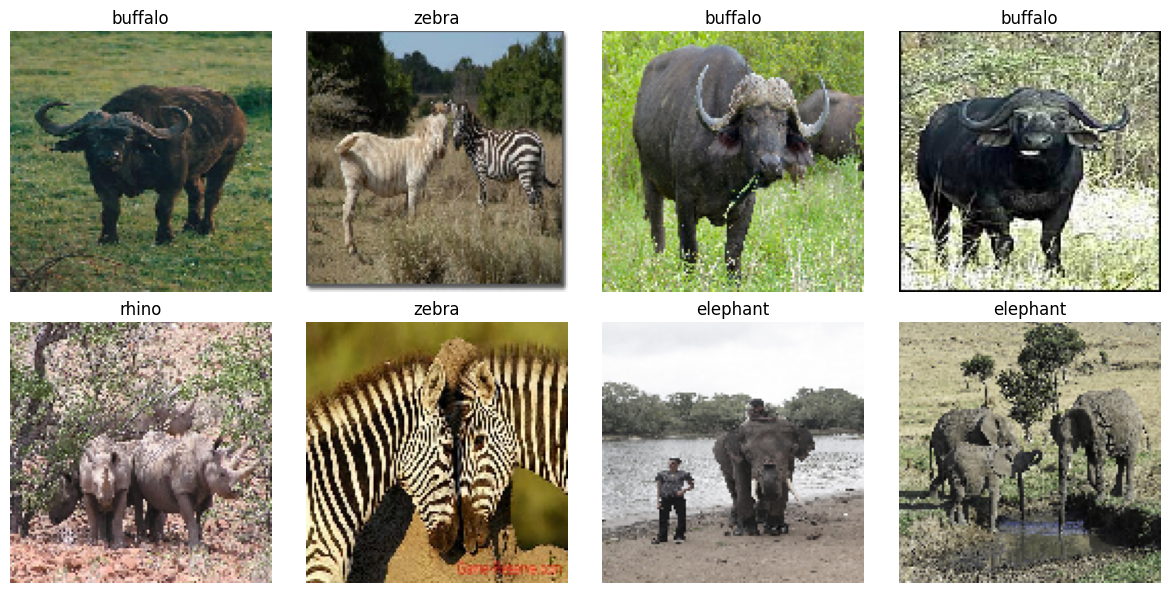

In [17]:
#verify the classes
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print(f"Classes found: {classes}")

image_paths = []
labels = []

for label in classes:
    class_dir = os.path.join(base_dir, label)
    for img_file in os.listdir(class_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(class_dir, img_file))
            labels.append(label)

# Display 8 sample images
plt.figure(figsize=(12, 6))
for i in range(8):
    idx = np.random.randint(0, len(image_paths))
    img = load_img(image_paths[idx], target_size=(128, 128))
    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    plt.title(labels[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [18]:
# 2. Resize all images to a fixed size (128x128) and normalize pixel values to 0-1
# 3. Encode class labels into integers
img_size = (128, 128)
X = []
y = []

# Create a mapping
class_map = {cls: i for i, cls in enumerate(classes)}
print(f"Class Mapping: {class_map}")

print("Loading and resizing images... this may take a moment.")
for img_path, label in zip(image_paths, labels):
    try:
        img = load_img(img_path, target_size=img_size)
        img_array = img_to_array(img)
        X.append(img_array)
        y.append(class_map[label])
    except Exception as e:
        print(f"Error loading {img_path}: {e}")

X = np.array(X, dtype='float32') / 255.0  # Normalize
y = np.array(y)

print(f"Data shape: {X.shape}")
print(f"Labels shape: {y.shape}")


Class Mapping: {'rhino': 0, 'buffalo': 1, 'elephant': 2, 'zebra': 3}
Loading and resizing images... this may take a moment.
Data shape: (1504, 128, 128, 3)
Labels shape: (1504,)


Train shape: (1052, 128, 128, 3)
Validation shape: (226, 128, 128, 3)
Test shape: (226, 128, 128, 3)


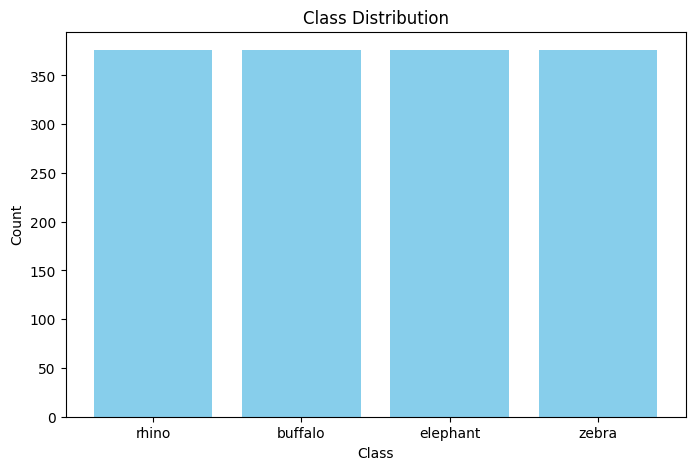

In [19]:
# 4. Split the dataset into train/validation/test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

# 5. Display a bar chart of class distribution
unique, counts = np.unique(y, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(classes, counts, color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [20]:
#Part B - Build a CNN
# 6. Build a CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(classes), activation='softmax') # Output layer
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,836 (28.20 MB)

 Trainable params: 7,392,836 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# 7. Train for 8 epochs
history = model.fit(
    X_train, y_train,
    epochs=8,
    validation_data=(X_val, y_val)
)

Epoch 1/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 930ms/step - accuracy: 0.2974 - loss: 2.2606 - val_accuracy: 0.5442 - val_loss: 1.0555
Epoch 2/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 914ms/step - accuracy: 0.5966 - loss: 0.9128 - val_accuracy: 0.5708 - val_loss: 1.0422
Epoch 3/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 922ms/step - accuracy: 0.7277 - loss: 0.7456 - val_accuracy: 0.6416 - val_loss: 0.8650
Epoch 4/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 30s 907ms/step - accuracy: 0.8462 - loss: 0.4730 - val_accuracy: 0.6549 - val_loss: 0.8183
Epoch 5/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 911ms/step - accuracy: 0.9224 - loss: 0.2986 - val_accuracy: 0.6549 - val_loss: 0.9185
Epoch 6/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 40s 892ms/step - accuracy: 0.9530 - loss: 0.1814 - val_accuracy: 0.6504 - val_loss: 0.9284
Epoch 7/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 859ms/step - accuracy: 0.9912 - loss: 0.0785 - val_accuracy: 0.6549 - val_loss: 1.0877
Epoch 8/8
33/33 ━━━━━━━━━━━━━━━━━━━━ 29s 884ms/step - accuracy: 0.9957 - loss: 0.0414 - val_accuracy: 0.

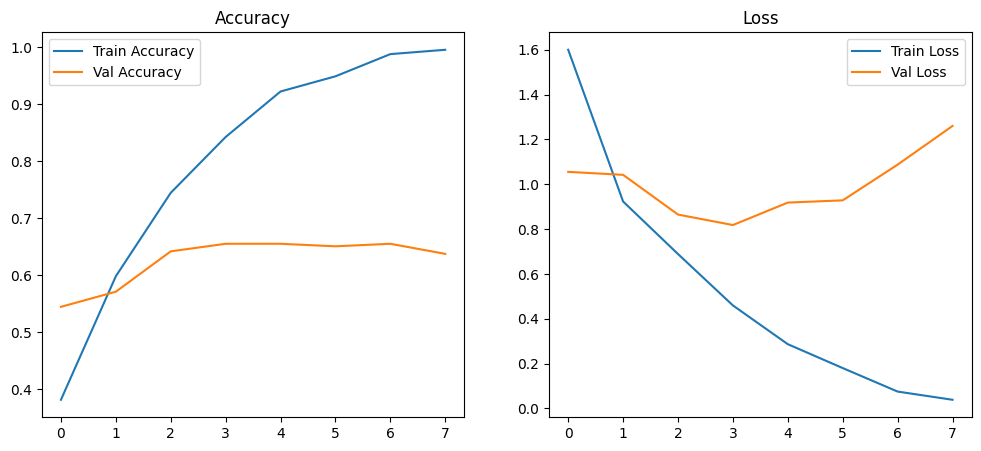

In [22]:
# Plot training vs validation accuracy and loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


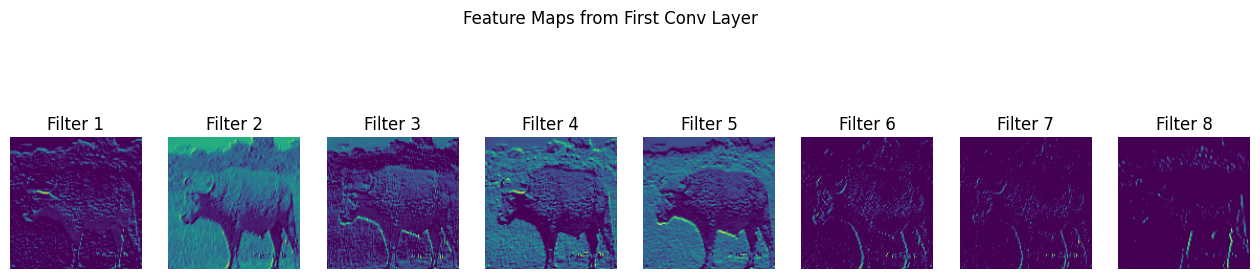

In [23]:
# 8. Feature Map Visualization
# Extract feature maps from the first convolution layer for one sample image
from tensorflow.keras.models import Model

# Create a model that outputs the first conv layer's activation
first_layer_model = Model(inputs=model.inputs, outputs=model.layers[0].output)

# Get one image
sample_img = X_test[0].reshape(1, 128, 128, 3)
feature_maps = first_layer_model.predict(sample_img)

# Plot the feature maps (first 8 filters)
plt.figure(figsize=(16, 4))
for i in range(8):
    plt.subplot(1, 8, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
    plt.axis('off')
    plt.title(f'Filter {i+1}')
plt.suptitle("Feature Maps from First Conv Layer")
plt.show()

In [24]:
#Part C - Evaluation

# 9. Generate predictions and compute metrics
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 188ms/step
Classification Report:
              precision    recall  f1-score   support

       rhino       0.63      0.54      0.58        57
     buffalo       0.60      0.77      0.67        56
    elephant       0.49      0.47      0.48        57
       zebra       0.86      0.77      0.81        56

    accuracy                           0.64       226
   macro avg       0.65      0.64      0.64       226
weighted avg       0.64      0.64      0.64       226



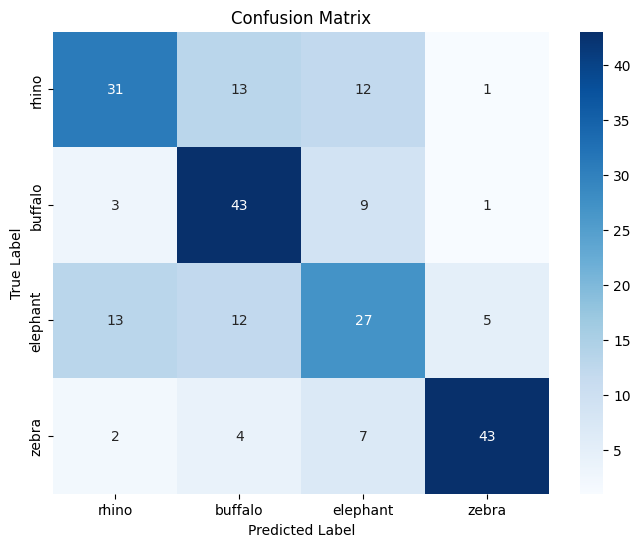

Observations:
1. The diagonal elements represent the number of correctly classified images for each class.
2. Off-diagonal elements represent misclassifications. High values here indicate confusion between specific pairs of animals.


In [25]:
# 10. Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print("Observations:")
print("1. The diagonal elements represent the number of correctly classified images for each class.")
print("2. Off-diagonal elements represent misclassifications. High values here indicate confusion between specific pairs of animals.")

In [26]:
# 11. Compute precision and recall manually given TP=30, FP=10, FN=20
TP = 30
FP = 10
FN = 20

precision_manual = TP / (TP + FP)
recall_manual = TP / (TP + FN)

print(f"\nManual Calculation (TP=30, FP=10, FN=20):")
print(f"Precision: {precision_manual:.2f}")
print(f"Recall: {recall_manual:.2f}")


Manual Calculation (TP=30, FP=10, FN=20):
Precision: 0.75
Recall: 0.60


In [27]:
# 12. Apply one improvement (Data Augmentation) and train again
print("\nTraining with Data Augmentation...")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Re-build model (to reset weights)
model_improved = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5), # Added Dropout
    Dense(len(classes), activation='softmax')
])

model_improved.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_improved = model_improved.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=3, # Train for 3 epochs as requested
    validation_data=(X_val, y_val)
)

print("Improved Model Evaluation:")
loss, acc = model_improved.evaluate(X_test, y_test)
print(f"Test Accuracy (Improved): {acc:.4f}")



Training with Data Augmentation...
Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 34s 972ms/step - accuracy: 0.2588 - loss: 2.2956 - val_accuracy: 0.3938 - val_loss: 1.2361
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 42s 995ms/step - accuracy: 0.4005 - loss: 1.2455 - val_accuracy: 0.4159 - val_loss: 1.3600
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 986ms/step - accuracy: 0.4318 - loss: 1.1363 - val_accuracy: 0.4469 - val_loss: 1.3393
Improved Model Evaluation:
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.5392 - loss: 1.2423
Test Accuracy (Improved): 0.5000
